In [444]:
%pip install --quiet gymnasium numpy matplotlib optuna

Note: you may need to restart the kernel to use updated packages.


In [445]:
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import numpy as np
import optuna
from optuna import logging

In [83]:
np.__version__

'2.2.0'

Directions: 0123 = up right down left


In [300]:
class CliffWalkEnv(gym.Env):
    DELTA = {
        0: np.array([-1, 0]),
        1: np.array([0, 1]),
        2: np.array([1, 0]),
        3: np.array([0, -1]),
    }
    TRUNCATE_TIME = 100

    def __init__(self):
        super().__init__()
        self.observation_space = spaces.MultiDiscrete([4, 11])
        self.action_space = spaces.Discrete(4)

        self._start = np.array([3, 0])
        self._goal = np.array([3, 10])

    def _clamp(self):
        i, j = self._state
        self._state = np.array([np.clip(i, 0, 3), np.clip(j, 0, 10)])

    def reset(self):
        self._state = self._start.copy()
        self._timesteps = 0
        self._total_rewards = 0
        return tuple(self._state), {}

    def step(self, action):
        self._state += CliffWalkEnv.DELTA[action]
        self._clamp()
        i, j = self._state
        if i == 3 and 1 <= j <= 9:
            reward = -100
            terminated = True
        else:
            reward = -1
            if np.array_equal(self._state, self._goal):
                terminated = True
            else:
                terminated = False
        self._timesteps += 1
        truncated = self._timesteps >= CliffWalkEnv.TRUNCATE_TIME
        if truncated:
            reward = -100
        self._total_rewards += reward

        return (
            tuple(self._state),
            reward,
            terminated,
            truncated,
            {"total_rewards": self._total_rewards} if terminated or truncated else {},
        )

In [284]:
env = CliffWalkEnv()
env.reset()

((np.int64(3), np.int64(0)), {})

In [298]:
env.step(2)

((np.int64(3), np.int64(10)), -1, True, False, {'total_rewards': -14})

In [394]:
def epsilon_greedy(epsilon, q, s):
    if np.random.random() < epsilon:
        return np.random.choice(range(4))
    return np.argmax(q[s])

In [438]:
def sarsa(alpha, gamma, epsilon, episodes):
    env = CliffWalkEnv()
    q = np.zeros((4, 11, 4))
    vis = np.zeros((4, 11))
    episode_rewards = []
    for _ in range(episodes):
        s, _ = env.reset()
        vis[s] += 1
        a = epsilon_greedy(epsilon, q, s)
        done = False
        while not done:
            s_prime, r, terminated, truncated, info = env.step(a)
            vis[s_prime] += 1
            a_prime = epsilon_greedy(epsilon, q, s_prime)
            q[s + (a,)] += alpha * (r + gamma * q[s_prime + (a_prime,)] - q[s + (a,)])
            s = s_prime
            a = a_prime
            done = terminated or truncated
        episode_rewards.append(info["total_rewards"])

    pi = np.argmax(q, axis=2)
    return pi, {"episode_rewards": episode_rewards, "vis": vis, "q": q}


def q_learning(alpha, gamma, epsilon, episodes):
    env = CliffWalkEnv()
    q = np.zeros((4, 11, 4))
    episode_rewards = []
    for _ in range(episodes):
        s, _ = env.reset()
        done = False
        while not done:
            a = epsilon_greedy(epsilon, q, s)
            s_prime, r, terminated, truncated, info = env.step(a)
            q[s + (a,)] += alpha * (r + gamma * np.max(q[s_prime]) - q[s + (a,)])
            s = s_prime
            done = terminated or truncated
        episode_rewards.append(info["total_rewards"])

    pi = np.argmax(q, axis=2)
    return pi, {"episode_rewards": episode_rewards, "q": q}

In [436]:
def objective(trial):
    alpha = trial.suggest_float("alpha", 0.05, 0.5, log=True)
    epsilon = trial.suggest_float("epsilon", 1e-4, 0.1, log=True)
    run_averages = []
    for run in range(3):
        _, info = q_learning(alpha, 1.0, epsilon, 200)
        run_averages.append(np.average(info["episode_rewards"][-50:]))
    return np.average(run_averages)


logging.set_verbosity(logging.INFO)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

[I 2024-12-22 17:16:47,134] A new study created in memory with name: no-name-5c4cd6f7-0011-4d36-9bf5-cbb1eb4b2e20
[I 2024-12-22 17:16:47,974] Trial 0 finished with value: -23.96666666666667 and parameters: {'alpha': 0.09403059687845904, 'epsilon': 0.013286191520689342}. Best is trial 0 with value: -23.96666666666667.
[I 2024-12-22 17:16:48,325] Trial 1 finished with value: -17.34 and parameters: {'alpha': 0.38910737599735246, 'epsilon': 0.02317862400404218}. Best is trial 1 with value: -17.34.
[I 2024-12-22 17:16:49,398] Trial 2 finished with value: -78.01333333333334 and parameters: {'alpha': 0.07259026622123207, 'epsilon': 0.0021395599582681593}. Best is trial 1 with value: -17.34.
[I 2024-12-22 17:16:49,827] Trial 3 finished with value: -16.099999999999998 and parameters: {'alpha': 0.2555256463299233, 'epsilon': 0.00886063344798895}. Best is trial 3 with value: -16.099999999999998.
[I 2024-12-22 17:16:50,456] Trial 4 finished with value: -20.573333333333334 and parameters: {'alpha':

In [437]:
study.best_params

{'alpha': 0.47102271377501154, 'epsilon': 0.0007987145857657901}

In [440]:
alpha = 0.5
gamma = 1
epsilon = 0.00

episodes = 500

pi_sarsa, info = sarsa(alpha, gamma, epsilon, episodes)
episode_rewards_sarsa = info["episode_rewards"]

pi_q, info = q_learning(alpha, gamma, epsilon, episodes)
episode_rewards_q = info["episode_rewards"]
q_q = info["q"]

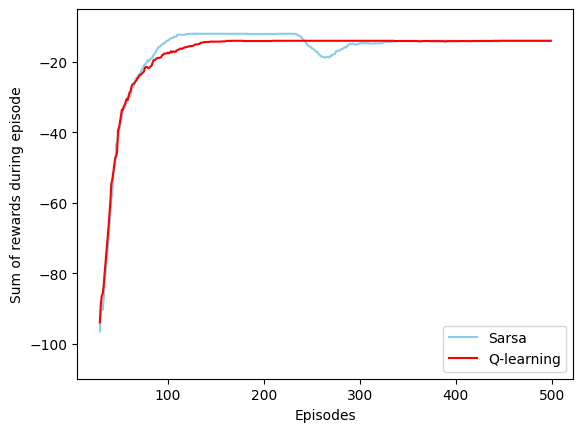

In [439]:
fig, ax = plt.subplots()

window_size = 30
kernel = np.ones(window_size) / window_size

ax.plot(
    range(window_size - 1, episodes),
    np.convolve(episode_rewards_sarsa, kernel, "valid"),
    color="skyblue",
    label="Sarsa",
)
ax.plot(
    range(window_size - 1, episodes),
    np.convolve(episode_rewards_q, kernel, "valid"),
    color="red",
    label="Q-learning",
)
ax.set_xlabel("Episodes")
ax.set_ylabel("Sum of rewards during episode")
ax.set_ylim([-110, -5])

ax.legend()

plt.show()

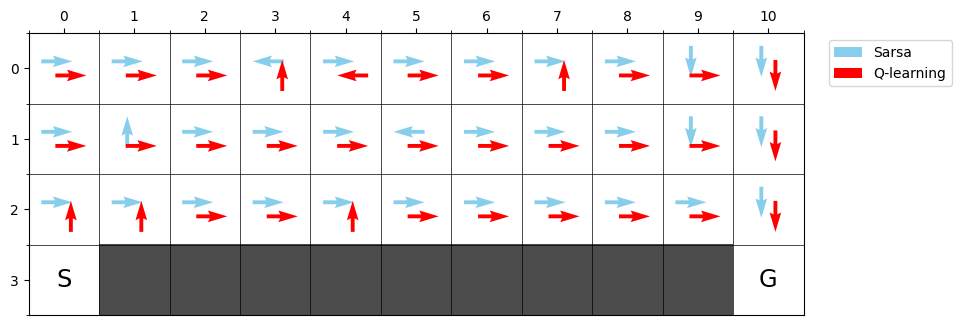

In [441]:
fig, ax = plt.subplots(figsize=(10, 6))

grid = np.ones_like(pi_sarsa, dtype=float)
grid[3, 1:10] = 0.3

ax.imshow(grid, cmap="gray", vmin=0, vmax=1)

ax.text(0, 3, "S", ha="center", va="center", color="k", size="xx-large")
ax.text(10, 3, "G", ha="center", va="center", color="k", size="xx-large")


xv, yv = np.meshgrid(np.arange(11), np.arange(3))
dx_sarsa = np.zeros_like(xv, dtype=float)
dy_sarsa = np.zeros_like(yv, dtype=float)
dx_q = np.zeros_like(xv, dtype=float)
dy_q = np.zeros_like(yv, dtype=float)

DIR_X = {0: 0, 1: 1, 2: 0, 3: -1}
DIR_Y = {0: -1, 1: 0, 2: 1, 3: -0}

for i in range(3):
    for j in range(11):
        dx_sarsa[i, j] = DIR_X[pi_sarsa[i, j]]
        dy_sarsa[i, j] = DIR_Y[pi_sarsa[i, j]]

        dx_q[i, j] = DIR_X[pi_q[i, j]]
        dy_q[i, j] = DIR_Y[pi_q[i, j]]

arrow_offset = 0.1
ax.quiver(
    xv - arrow_offset,
    yv - arrow_offset,
    dx_sarsa,
    dy_sarsa,
    color="skyblue",
    angles="xy",
    scale=25,
    width=5e-3,
    pivot="mid",
    label="Sarsa",
)
ax.quiver(
    xv + arrow_offset,
    yv + arrow_offset,
    dx_q,
    dy_q,
    color="red",
    angles="xy",
    scale=25,
    width=5e-3,
    pivot="mid",
    label="Q-learning",
)


ax.set_xticks(range(11))
ax.set_yticks(range(4))
ax.set_xticks(np.arange(-0.5, pi_sarsa.shape[1], 1), minor=True)
ax.set_yticks(np.arange(-0.5, pi_sarsa.shape[0], 1), minor=True)
ax.xaxis.tick_top()

ax.grid(which="minor", color="k", linewidth=0.5)
ax.legend(bbox_to_anchor=(1.2, 1))

plt.show()

In [442]:
np.round(np.max(q_q, axis=2))

array([[-11., -11., -10.,  -9.,  -8.,  -7.,  -6.,  -6.,  -5.,  -4.,  -3.],
       [-12., -11., -10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.],
       [-13., -12., -10.,  -9.,  -9.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.],
       [-14.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]])

In [346]:
vis

array([[550., 501., 464., 448., 392., 281., 233., 204., 237., 217., 182.],
       [833., 707., 644., 552., 603., 679., 617., 541., 530., 539., 491.],
       [842., 278., 221., 153., 207., 225., 126., 129.,  81.,  92., 473.],
       [747.,  28.,   9.,   6.,   6.,   4.,   5.,   5.,   6.,   6., 413.]])

In [263]:
q = np.zeros((4, 11, 4))
q[tuple(np.array([1, 2]))]
(1, 2), (3,)
# [np.random.choice(range(4)) for _ in range(100)]
# np.argmax(q[(3, 0)])
np.array([1, 2]) == np.array([1, 2])

array([ True,  True])

In [141]:
pi = np.random.randint(0, 4, (4, 11))
# pi[3][10]
pi
x, y = np.array([1, 2]) + np.array([1, 2])
x, y

(np.int64(2), np.int64(4))

In [124]:
pi

array([[2, 3, 2, 2, 0, 2, 2, 0, 3, 0, 0],
       [0, 3, 3, 2, 0, 1, 1, 2, 0, 1, 2],
       [2, 2, 3, 1, 0, 3, 2, 0, 3, 3, 3],
       [0, 3, 3, 1, 2, 0, 1, 2, 0, 0, 2]])

In [98]:
xv[2, 3]

np.int64(3)

In [59]:
grid.dtype

dtype('int64')